In [217]:
# Data Manipulation
import psycopg2
import pandas as pd
import numpy as np
import datetime, time

# Exploratory Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import graphlab as gl
gl.canvas.set_target('ipynb')
sns.set_style('white')

# Interactive Graphics

# To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py

# Useful Python/Plotly tools
import plotly.tools as tls

# Graph objects to piece together plots
from plotly.graph_objs import *

%matplotlib inline

In [164]:
# Setup connection to Pecan Street Dataport
try:
    conn = psycopg2.connect("dbname='postgres' user='2c53Epq3kSyQ' host='dataport.pecanstreet.org' port='5434' password=''")
except:
    "Error: Check there aren't any open connections in notebook or pgAdmin"

In [209]:
conn.close()

In [ ]:
# psql -h dataport.pecanstreet.org -p 5434 -U 2c53Epq3kSyQ -W '' postgres

In [69]:
cursor = conn.cursor()

In [78]:
cursor.execute("SELECT dataid, localhour, SUM(use) FROM university.electricity_egauge_hours GROUP BY dataid, localhour")
for row in cursor:
    print row
    if row == None:
        break

In [44]:
electricity_df = pd.read_sql("SELECT localhour, SUM(use) AS usage, SUM(air1) AS cooling, SUM(furnace1) AS heating, \
                             SUM(car1) AS electric_vehicle \
                             FROM university.electricity_egauge_hours \
                             WHERE dataid = 114 AND use > 0 \
                             GROUP BY dataid, localhour \
                             ORDER BY localhour", conn)

In [45]:
electricity_df['localhour'] = electricity_df.localhour.apply(pd.to_datetime)

In [46]:
electricity_df.set_index('localhour', inplace=True)

In [47]:
electricity_df.fillna(value=0.0, inplace=True)

In [48]:
# Min: 2013-10-16 00:00:00
# Max: 2016-02-26 08:00:00
# Count: 20,721
electricity_df.tail()

,usage,cooling,heating,electric_vehicle
localhour,,,,
2016-02-26 04:00:00,0.987767,0.0011,0.014033,0.000000
2016-02-26 05:00:00,0.444633,0.0000,0.062733,0.001250
2016-02-26 06:00:00,0.302900,0.0000,0.073383,0.000000
2016-02-26 07:00:00,0.794867,0.0000,0.074467,0.391400
2016-02-26 08:00:00,3.625279,0.0000,0.105697,3.357758


In [9]:
electricity_df_nocar = electricity_df[['usage', 'cooling', 'heating']]

In [10]:
electricity_df_car = electricity_df[['usage','electric_vehicle']]

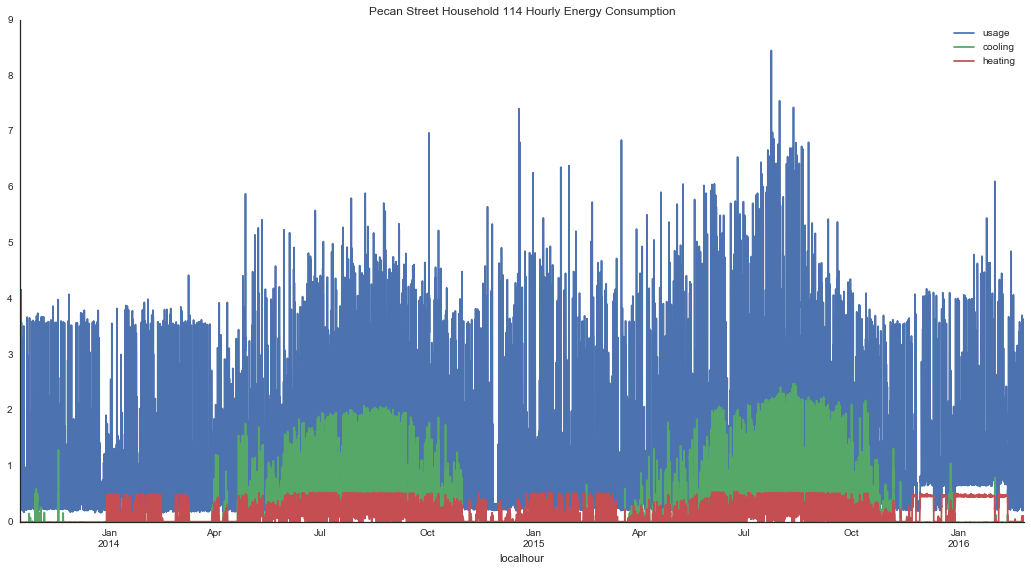

In [166]:
electricity_df_nocar.plot(figsize=(18,9), title="Pecan Street Household 114 Hourly Energy Consumption")
sns.despine();

## Turns out house 114 has an electric car!

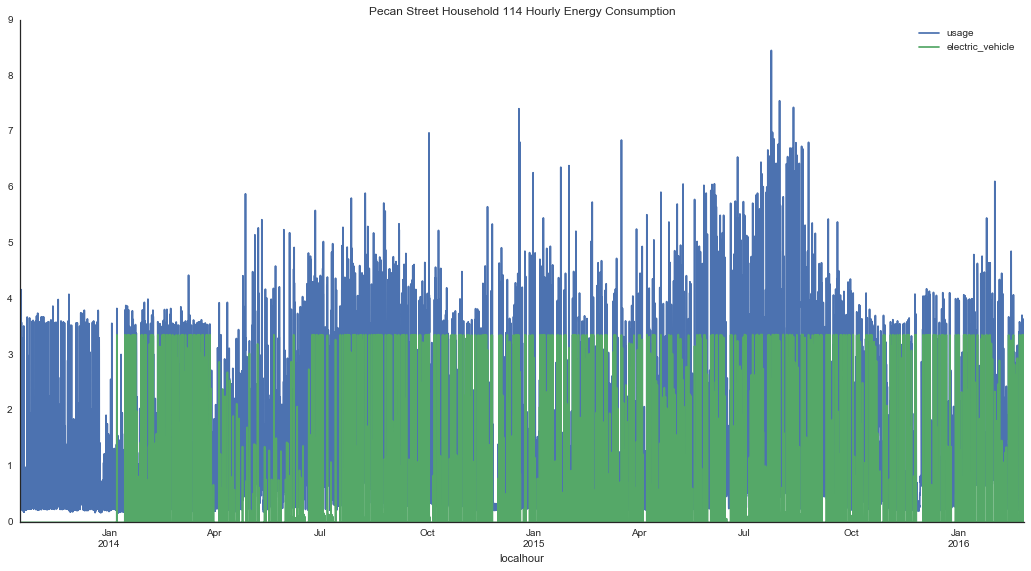

In [167]:
electricity_df_car.plot(figsize=(18,9), title="Pecan Street Household 114 Hourly Energy Consumption")
sns.despine();

In [ ]:
# Geohash: 30.292432 -97.699662 Austin, TX

In [24]:
from bokeh.io import output_file, output_notebook
from bokeh.plotting import show
from bokeh.models import GMapPlot, GMapOptions, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool

In [25]:
map_options = GMapOptions(lat=30.292432, lng=-97.699662, map_type="roadmap", zoom=11)

In [26]:
plot = GMapPlot(x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options, title="Austin, TX")

In [27]:
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

In [28]:
output_notebook()
# output_file("gmap_plot.html")

BokehJS successfully loaded.

In [13]:
show(plot);

In [13]:
weather_df = pd.read_sql("SELECT localhour, temperature \
                             FROM university.weather \
                             WHERE localhour BETWEEN '2013-10-16 00:00:00'::timestamp AND \
                             '2016-02-26 08:00:00'::timestamp \
                             AND latitude = 30.292432 \
                             ORDER BY localhour", conn)

In [18]:
weather_df['localhour'] = weather_df.localhour.apply(pd.to_datetime)

In [19]:
weather_df.set_index('localhour', inplace=True)

In [20]:
weather_df.fillna(value=0.0, inplace=True)

In [24]:
# Count: 20,673
weather_df.count()

temperature    20673
dtype: int64

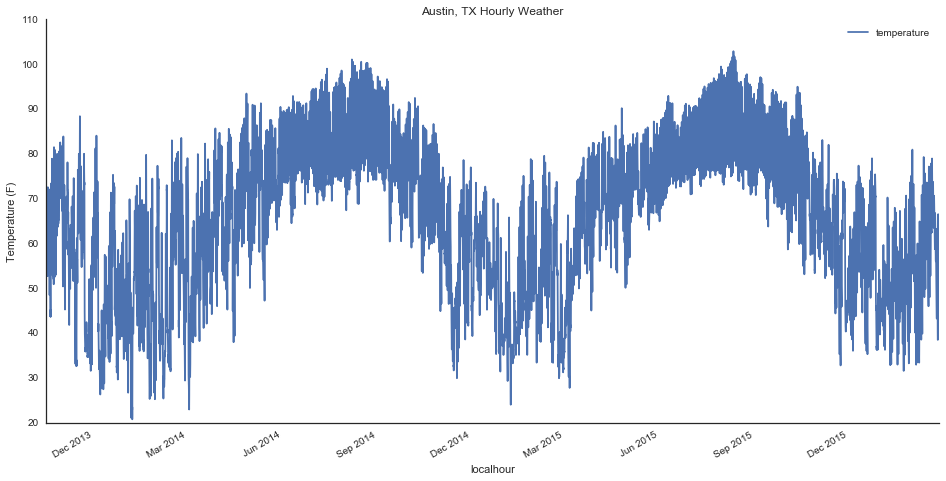

In [208]:
weather_df.plot(figsize=(16,8), title='Austin, TX Hourly Weather')
plt.ylabel('Temperature (F)')
sns.despine();

## Plotly

In [5]:
tls.set_credentials_file(stream_ids=[
        "bcjrhlt0lz",
        "pkkb5aq85l",
        "c5ygaf48l0",
        "l3nh9ls79j"
    ])

In [7]:
stream_ids = tls.get_credentials_file()['stream_ids']
stream_ids

[u'bcjrhlt0lz', u'pkkb5aq85l', u'c5ygaf48l0', u'l3nh9ls79j']

In [9]:
# help(Stream)

In [329]:
electricity = Stream(
    token="c5ygaf48l0",  # (!) link stream id to 'token' key
    maxpoints=500      # (!) keep a max of 80 pts on screen
)
weather = Stream(
    token="l3nh9ls79j",  # (!) link stream id to 'token' key
    maxpoints=500      # (!) keep a max of 80 pts on screen
)

In [330]:
trace1 = Scatter(x=[], y=[], mode='lines+markers', stream=electricity, name='electricity usage')
trace2 = Scatter(x=[], y=[], mode='lines+markers', stream=weather, name='weather')
data = Data([trace1,trace2])

In [331]:
# Add title to layout object
layout = Layout(title='Pecan Street Sensor Data')

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send fig to Plotly, initialize streaming plot, open new tab
py.iplot(fig, filename='Pecan Street Streaming Electricity Usage')

In [332]:
# (@) Make instance of the Stream link object, 
#     with same stream id as Stream id object
s1 = py.Stream("c5ygaf48l0")
s2 = py.Stream("l3nh9ls79j")

# (@) Open the stream
s1.open()
s2.open()

In [84]:
i = 0    # a counter
k = 5    # some shape parameter
k2 = 10
N = 200  # number of points to be plotted

# Delay start of stream by 5 sec (time to switch tabs)


while i<N:
    i += 1   # add to counter

    # Current time on x-axis, random numbers on y-axis
    x = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    y = (np.cos(k*i/50.)*np.cos(i/50.)+np.random.randn(1))[0]
    
    x2 = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    y2 = (np.cos(k2*i/50.)*np.cos(i/50.)+np.random.randn(1))[0]
    
    # (-) Both x and y are numbers (i.e. not lists nor arrays)

    # (@) write to Plotly stream!
    s1.write(dict(x=x, y=y))
    s2.write(dict(x=x2, y=y2))

    # (!) Write numbers to stream to append current data on plot,
    #     write lists to overwrite existing data on plot (more in 7.2).

    time.sleep(0.08)  # (!) plot a point every 80 ms, for smoother plotting

# (@) Close the stream when done plotting
s1.close()
s2.close()

NameError: name 's1' is not defined

In [213]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

'2016-03-03 23:29:26.873469'

In [269]:
# tls.embed('streaming-demos','12')

In [204]:
class PlotlyStream(object):
    
    def __init__(self, electricity_data, weather_data, stream_tokens):
        self.electricity = electricity_data
        self.weather = weather_data
        self.tokens = stream_tokens
    
    def create_plot(self, chart_title, x_title, y_title, maxpoints):
        """Method to generate Plotly plot in notebook for rendering streaming data"""
        
        e_stream = Stream(token= self.tokens[0], maxpoints= maxpoints)
        trace1 = Scatter(x=[], y=[], mode='lines+markers', stream = e_stream, name='Usage')
        
#         w_stream = Stream(token= self.tokens[1], maxpoints= maxpoints)
#         trace2 = Scatter(x=[], y=[], mode='lines+markers', stream = w_stream, yaxis='y2', name='Temp')
        
#         data = Data([trace1, trace2])
        data = Data([trace1])
        
        # Initialize layout object
        layout = Layout(title= chart_title, 
                        showlegend=True,
                        xaxis= dict(title= x_title,
                                    autorange=True,
                                    range= [self.electricity.index.min(),self.electricity.index.max()],
                                    ticks='outside',
                                    type='date'
                                  ),
                        yaxis= dict(title = y_title,
                                    autorange=True,
                                    range=[self.electricity.min(),self.electricity.index.max()],
                                  ),
#                         yaxis2 = dict(title = y2_title,
#                                       range=[self.weather.min(), self.weather.max()],
#                                       overlaying='y',
#                                       side='right'
#                                      ),
                        hovermode='closest'
                       )
        
        # Create figure object
        fig = Figure(data=data, layout=layout)
        
        # (@) Send fig to Plotly, initialize streaming plot, open new tab
        return py.iplot(fig, filename='Pecan Street Streaming Electricity Usage')
    
    def plot_stream(self, plot_freq=0.2, start_delay=0.1):
        """Method to write data to Plotly servers to render on graph"""
        
        s1 = py.Stream(self.tokens[0])
#         s2 = py.Stream(self.tokens[1])
        
        s1.open()
#         s2.open()
        
        counter = 0
        N = 1000
        
        # Create small delay before plotting begins
#         time.sleep(start_delay)
        
        electricity = self.electricity.iterrows()
#         weather = self.weather.iterrows()
        
        while counter < N:
            counter += 1
            
            timestamp1, usage = electricity.next()
#             timestamp2, temperature = weather.next()
            
            # .strftime('%Y-%m-%d %H.%f')
            
#             times = []
#             usages = []
#             temperatures = []
            
            x1 = timestamp1.strftime('%Y-%m-%d %H')
            y1 = usage
            
#             x2 = timestamp2.strftime('%Y-%m-%d %H:%M:%S.%f')
#             y2 = temperature
            
            s1.write(dict(x=x1, y=y1))
#             time.sleep(plot_freq)
#             s2.write(dict(x=x2, y=y2))
            time.sleep(plot_freq)
        
        s1.close()
#         s2.close()

In [205]:
PecanStreet = PlotlyStream(electricity_df_usage, weather_df, ["pkkb5aq85l","c5ygaf48l0"])

In [206]:
PecanStreet.create_plot("Pecan Street Household 114 Electricity Usage", 
                        "Time (Hours)", 
                        "KwH (Kilowats per Hour)",
                        100)

In [207]:
PecanStreet.plot_stream()

KeyboardInterrupt: 

In [195]:
electricity_df_usage = electricity_df[electricity_df.columns[:1]]

In [284]:
electricity_df_usage.values

array([[ 2.0505    ],
       [ 1.42948333],
       [ 1.15866667],
       ..., 
       [ 0.3029    ],
       [ 0.79486667],
       [ 3.62527907]])

## GraphLab (to the rescue)

In [215]:
electricity_sf = gl.SFrame(data=electricity_df)
electricity_sf.tail()

usage,cooling,heating,electric_vehicle,changepoint_score
0.223766666667,0.0,0.013,0.0,1.14211652363e-05
0.321166666667,0.0,0.013,0.0014,1.4603252804e-05
1.09625,0.00141666666667,0.0137,0.00258333333333,0.000193318899915
0.730633333333,0.0,0.0133333333333,0.0026,nan
0.75895,0.0,0.0135166666667,0.0,nan
0.987766666667,0.0011,0.0140333333333,0.0,nan
0.444633333333,0.0,0.0627333333333,0.00125,nan
0.3029,0.0,0.0733833333333,0.0,nan
0.794866666667,0.0,0.0744666666667,0.3914,nan
3.62527906977,0.0,0.105696969697,3.35775757576,nan


In [219]:
electricity_sf.show(view='Line Chart')

In [26]:
model = gl.anomaly_detection.bayesian_changepoints.create(electricity_sf, feature='usage', lag=7)

In [27]:
model.summary()

Class                                   : BayesianChangepointsModel

Schema
------
Number of examples                      : 20721
Feature name                            : usage
Expected run length                     : 250.0
Lag observations                        : 7

Training summary
----------------
Total training time (seconds)           : 1.4251

Accessible fields
-----------------
scores                                  : Changepoint score for each row in the input dataset.


In [28]:
scores = model['scores']

In [43]:
scores.head()

row_id,changepoint_score,usage,model_update_time
0,0.00392632331998,2.0505,2016-03-0609:22:13.893883 ...
1,0.00546546475609,1.42948333333,2016-03-0609:22:13.893883 ...
2,0.00209993441427,1.15866666667,2016-03-0609:22:13.893883 ...
3,0.00183265710535,1.01605,2016-03-0609:22:13.893883 ...
4,0.00239739992037,0.822316666667,2016-03-0609:22:13.893883 ...
5,0.00273365557582,0.59295,2016-03-0609:22:13.893883 ...
6,0.00272753831362,0.356183333333,2016-03-0609:22:13.893883 ...
7,0.00256505071712,2.68118333333,2016-03-0609:22:13.893883 ...
8,0.000698557960109,3.62593333333,2016-03-0609:22:13.893883 ...
9,0.000290759017045,3.60446666667,2016-03-0609:22:13.893883 ...


In [29]:
sketch = scores['changepoint_score'].sketch_summary()
threshold = sketch.quantile(0.995)
changepoints = scores[scores['changepoint_score'] > threshold]
changepoints.print_rows(4, max_row_width=100, max_column_width=30)

+--------+-------------------+---------------+----------------------------+
| row_id | changepoint_score |     usage     |     model_update_time      |
+--------+-------------------+---------------+----------------------------+
|  151   |   0.852634716179  | 1.45423333333 | 2016-03-06 09:22:13.893883 |
|  248   |   0.771894425497  |    2.37755    | 2016-03-06 09:22:13.893883 |
|  271   |   0.712608106012  | 1.93941666667 | 2016-03-06 09:22:13.893883 |
|  848   |   0.770690798574  | 1.92871666667 | 2016-03-06 09:22:13.893883 |
+--------+-------------------+---------------+----------------------------+
[109 rows x 4 columns]



In [67]:
electricity_df['changepoint_score'] = scores['changepoint_score']

In [70]:
electricity_df.changepoint_score = electricity_df.changepoint_score.astype('float64')

In [179]:
def plot_changepoints(electricity_df, weather_df, quantile=0.995):
    """Function to plot changepoints on time series"""
    
    # Referenced: http://matplotlib.org/examples/api/two_scales.html
    fig, ax1 = plt.subplots(figsize=(24,10))
    ax1.plot(electricity_df.index, electricity_df.usage)
    plt.plot(electricity_df.index, electricity_df.electric_vehicle)
    ax1.set_xlabel('Time (h)')
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('KwH (Kilowats Per Hour)', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    changepoint_ts = electricity_df.index[electricity_df.changepoint_score > electricity_df.changepoint_score.quantile(quantile)]
    for changepoint in changepoint_ts:
        plt.axvline(changepoint, c='r')
    plt.legend()

    ax2 = ax1.twinx()
    ax2.plot(weather_df.index, weather_df.temperature, 'm--')
    ax2.set_ylabel('Temperature (F)', color='m')
    for ytick in ax2.get_yticklabels():
        ytick.set_color('m')
    plt.show() 

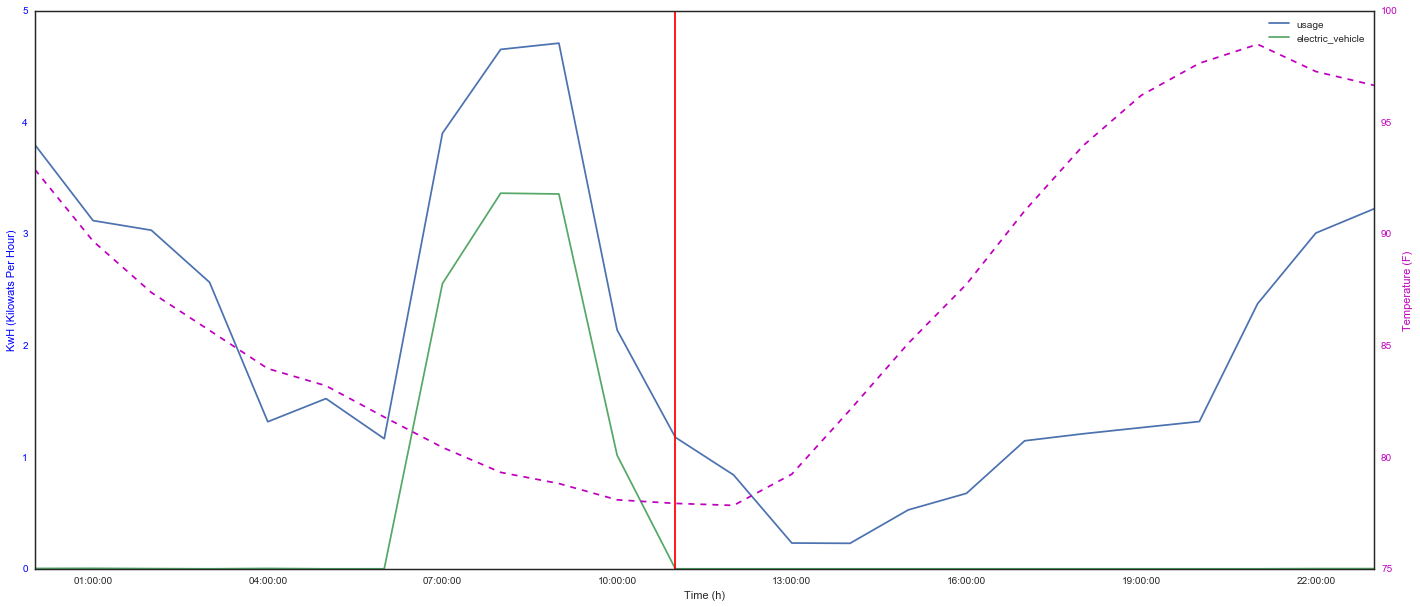

In [211]:
plot_changepoints(electricity_df['2014-08-18'], weather_df['2014-08-18']);

In [150]:
electricity_sf.show(view='Line Chart')

In [53]:
weather_sf = gl.SFrame(data=weather_df)

In [54]:
weather_sf.head()

localhour,temperature
2013-10-16 05:00:00+00:00,59.44
2013-10-16 06:00:00+00:00,57.53
2013-10-16 07:00:00+00:00,57.53
2013-10-16 08:00:00+00:00,56.74
2013-10-16 09:00:00+00:00,56.07
2013-10-16 10:00:00+00:00,55.76
2013-10-16 11:00:00+00:00,55.42
2013-10-16 12:00:00+00:00,54.07
2013-10-16 13:00:00+00:00,54.51
2013-10-16 14:00:00+00:00,55.08


In [35]:
weather_ts = gl.TimeSeries(data=weather_sf, index='localhour')

In [41]:
weather_ts.head()

localhour,temperature
2013-10-16 05:00:00+00:00,59.44
2013-10-16 06:00:00+00:00,57.53
2013-10-16 07:00:00+00:00,57.53
2013-10-16 08:00:00+00:00,56.74
2013-10-16 09:00:00+00:00,56.07
2013-10-16 10:00:00+00:00,55.76
2013-10-16 11:00:00+00:00,55.42
2013-10-16 12:00:00+00:00,54.07
2013-10-16 13:00:00+00:00,54.51
2013-10-16 14:00:00+00:00,55.08


In [57]:
weather_sf.show(view='Line Chart')

## Amazon RDS (Postgres)

## Amazon Kinesis